# Building Unsupervised AI Model to forecast sales anomaly
Method: Neural Network Regression

Process:
- Modelling data by aggregate orders line and merging it to orders info
- Predict standard value of HMS product within orders
- Differrence between predicted value and actual value will define ***anomaly flag***

Features to be used:
- Wholesaler
- Retailer
- Line Count
- Line of HMS Product
- Sum Qty of Product
- Sum Qty of HMS 
- Value



## Load modules and read data

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
orders = pd.read_csv("datasource/train_data/train_orders.csv")
orders = orders[orders["anomaly_label"]==0]
prods = pd.read_csv("datasource/train_data/train_order_products.csv")
print("orders:",len(orders))
print("prods:",len(prods))

orders: 9635
prods: 113606


# Check for missing fields

In [19]:
print(orders.isna().sum())
orders.head(2)

id                  0
wholesaler_id       0
retailer_id         0
buyer_type          0
shipping_type       0
order_type          0
book_time           0
last_status         0
last_status_time    0
anomaly_label       0
dtype: int64


,id,wholesaler_id,retailer_id,buyer_type,shipping_type,order_type,book_time,last_status,last_status_time,anomaly_label
0,5270143,154524,104735,retailer,pick-up,app,8/29/2020 15:53,siap-diambil,8/29/2020 16:06,0
1,5331813,137063,103017,retailer,pick-up,app,9/1/2020 16:10,siap-diambil,9/8/2020 11:24,0


In [20]:
prods.isna().sum()

id                     0
sku_id                 0
brand               1386
packaging              0
packaging_amount      60
amount                 0
price                  0
book_time              0
last_status            0
last_status_time       0
dtype: int64

Only ***brand*** is missing, we can assign ***'Other'*** there as default value, and check again, missing value should be updated

In [21]:
prods["brand"].fillna('Other', inplace=True)
prods["packaging_amount"].fillna(1, inplace=True)
prods.isna().sum()

id                  0
sku_id              0
brand               0
packaging           0
packaging_amount    0
amount              0
price               0
book_time           0
last_status         0
last_status_time    0
dtype: int64

## Add fields to be used as features for calculation
Will need to add more feature to be used as features

Name of feature should be sef expanatory

In [22]:
prods["is_hms"] = prods.apply(lambda x: 1 if str(x.brand).lower().find("sampoerna") > 0 else 0, axis=1)
prods["qty"] = prods["packaging_amount"] * prods["amount"]
prods["value"] = prods["price"] * prods["amount"]
prods["qty_hms"] = prods.apply(lambda x: x.qty if x.is_hms==1 else 0, axis=1)
prods["value_hms"] = prods.apply(lambda x: x.value if x.is_hms==1 else 0, axis=1)

## Validate if new fields exist

In [23]:
prods.head(2)

,id,sku_id,brand,packaging,packaging_amount,amount,price,book_time,last_status,last_status_time,is_hms,qty,value,qty_hms,value_hms
0,4822643,027.988412.000,[object Object],PCS,1.0,10,2250,2020-08-10 02:13:25,disetujui,2020-08-10 02:13:25,0,10.0,22500,0.0,0
1,3800278,001.015215.001,Others,BKS,1.0,2,15500,2020-06-22 12:17:47,disetujui,2020-06-22 12:17:47,0,2.0,31000,0.0,0


## Add ***trx_date*** to orders

In [24]:
orders["trx_time"] = pd.to_datetime(orders["book_time"])
orders["trx_date"] = orders["trx_time"].dt.year*10000+orders["trx_time"].dt.month*100+orders["trx_time"].dt.day
orders.head(2)

,id,wholesaler_id,retailer_id,buyer_type,shipping_type,order_type,book_time,last_status,last_status_time,anomaly_label,trx_time,trx_date
0,5270143,154524,104735,retailer,pick-up,app,8/29/2020 15:53,siap-diambil,8/29/2020 16:06,0,2020-08-29 15:53:00,20200829
1,5331813,137063,103017,retailer,pick-up,app,9/1/2020 16:10,siap-diambil,9/8/2020 11:24,0,2020-09-01 16:10:00,20200901


## Joining Orders into Products

In [25]:
order_fields = ["id","wholesaler_id","retailer_id","shipping_type","order_type","trx_date"]
joined = prods.merge(orders[order_fields],how="right",on="id").drop(columns=["last_status","last_status_time","book_time"])

In [26]:
ms_prod = pd.DataFrame({
    'sku_id': prods['sku_id'].unique()
}).reset_index().rename(columns={'index':'prod_id'})
joined = joined.merge(ms_prod, how="left", on="sku_id")
joined.head(2)

,id,sku_id,brand,packaging,packaging_amount,amount,price,is_hms,qty,value,qty_hms,value_hms,wholesaler_id,retailer_id,shipping_type,order_type,trx_date,prod_id
0,4822643,027.988412.000,[object Object],PCS,1.0,10,2250,0,10.0,22500,0.0,0,56644,22595,pick-up,app,20200810,0
1,4822643,003.728809.000,PT.Sari Incofood Corporation,PAK,3.0,3,46250,0,9.0,138750,0.0,0,56644,22595,pick-up,app,20200810,3762


# Observe Data
First lets check data correllation, and remove uneccessary columns

From correllation below we can see some features are very related, because unsupervised we need to choose only one for each of those

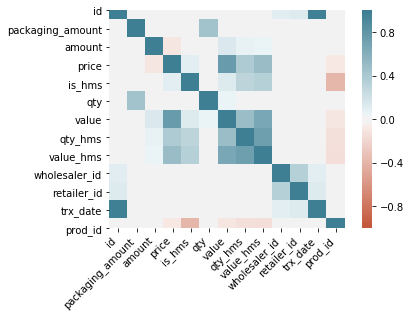

In [27]:
import seaborn as sns

def show_heatmap(df):
    ax = sns.heatmap(
        df.corr(),
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

show_heatmap(joined)

In [28]:
joined = joined.drop(columns=["packaging_amount","price","amount","packaging_amount"])
joined.head(2)

,id,sku_id,brand,packaging,is_hms,qty,value,qty_hms,value_hms,wholesaler_id,retailer_id,shipping_type,order_type,trx_date,prod_id
0,4822643,027.988412.000,[object Object],PCS,0,10.0,22500,0.0,0,56644,22595,pick-up,app,20200810,0
1,4822643,003.728809.000,PT.Sari Incofood Corporation,PAK,0,9.0,138750,0.0,0,56644,22595,pick-up,app,20200810,3762


## Aggregate and merge, will be used as train data

In [29]:
prod_sum = prods.groupby("id").agg(
    {"is_hms":{"line_count":"count","line_hms":"sum"}, 
    "qty":{"qty":"sum"}, "qty_hms":{"qty_hms":"sum"},"value":{"value":"sum"}, "value_hms":{"value_hms":"sum"}})
prod_sum.columns = prod_sum.columns.droplevel(0)
prod_sum = prod_sum.reset_index()

orders_sum = orders[orders["anomaly_label"]==0].merge(prod_sum, how="left", on="id")
orders_sum["ts"] = orders_sum.apply(lambda x: x["trx_time"].timestamp(), axis=1)
orders_sum.to_csv("datamodel/ordersum.csv", index=False)
orders_sum.head(2)

,id,wholesaler_id,retailer_id,buyer_type,shipping_type,order_type,book_time,last_status,last_status_time,anomaly_label,trx_time,trx_date,line_count,line_hms,qty,qty_hms,value,value_hms,ts
0,5270143,154524,104735,retailer,pick-up,app,8/29/2020 15:53,siap-diambil,8/29/2020 16:06,0,2020-08-29 15:53:00,20200829,6,6,44.0,44.0,844750,844750,1.598716e+09
1,5331813,137063,103017,retailer,pick-up,app,9/1/2020 16:10,siap-diambil,9/8/2020 11:24,0,2020-09-01 16:10:00,20200901,1,1,20.0,20.0,316000,316000,1.598977e+09


## Prepare AI model function

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, robust_scale

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def make_aimodel(model_name='unsupervised_sales_model', wsid=[], test_size=0.2, epochs=10, batch_size=256):
    if len(wsid) <= 5:
        print("Build AI model for wholesaler {0}".format(wsid))
    else:
        print("Build AI model for wholesalers {0}...".format(wsid[:4]))

    cols = ["wholesaler_id","retailer_id","line_hms","qty_hms","value_hms"]
    data = orders_sum.drop(
        columns=["id","trx_date"]) if len(wsid)==0 else orders_sum[orders_sum["wholesaler_id"].isin(wsid)].drop(columns=["id","trx_date"])
    data = data[data["line_hms"]>0][cols]
    print("Data count: {0}".format(len(data)))
    
    train, test = train_test_split(data, test_size=test_size)
    train_mean = np.mean(train, axis=0)
    train_std = np.std(train, axis=0)
    train_ds = (train - train_mean) / train_std
  
    model = tf.keras.Sequential([
        layers.Dense(8, activation='relu', input_shape=[len(cols)-1]),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)])

    model.compile(optimizer="adam",
                loss="mse",metrics=["mae","mse"])

    # train
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model.fit(
        train_ds[cols[:-1]], train_ds[cols[-1]], 
        epochs=epochs, validation_split=test_size, verbose=0,
        callbacks=[early_stop,PrintDot()])
    model.save("aimodel/{0}".format(model_name))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
    print()
    print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))
    pd.DataFrame(train_mean, columns=["value"]).transpose().to_csv("aimodel/{}/mean.csv".format(model_name))
    pd.DataFrame(train_std, columns=["value"]).transpose().to_csv("aimodel/{}/std.csv".format(model_name))
    return hist, train_mean, train_std

## Create the model and check the accuracy

In [31]:
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim(bottom=0)
    #plt.ylim([0, float(hist["val_mse"].tail(1))*2.2])

hist, mean, std = make_aimodel(epochs=20)

Build AI model for wholesaler []
Data count: 7850

....................
Final Root Mean Square Error on validation set: 0.518


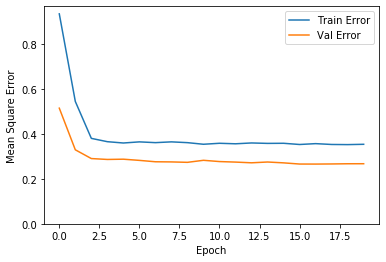

In [32]:
plot_history(hist)